In [1]:
# Analysis imports
import numpy as np
import pandas as pd
from scipy import special
from random import sample

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Modeling imports
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection  import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

# Miscellaneous imports
import itertools
from datetime import timedelta
from IPython.display import display

# Miscellaneous settings
pd.options.display.max_seq_items = 2000

D:\WinPython\python-3.6.5.amd64\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\WinPython\python-3.6.5.amd64\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# doc du lieu
fraud_df = pd.read_csv("DATA_project/Fraud/Fraud_Data.csv", header=0)

# 
ISP_df = pd.read_csv("DATA_project/Fraud/IpAddress_to_Country.csv", header=0) 

In [6]:
fraud_df.describe()

user_id  purchase_value            age    ip_address  \
count  151112.000000   151112.000000  151112.000000  1.511120e+05   
mean   200171.040970       36.935372      33.140704  2.152145e+09   
std    115369.285024       18.322762       8.617733  1.248497e+09   
min         2.000000        9.000000      18.000000  5.209350e+04   
25%    100642.500000       22.000000      27.000000  1.085934e+09   
50%    199958.000000       35.000000      33.000000  2.154770e+09   
75%    300054.000000       49.000000      39.000000  3.243258e+09   
max    400000.000000      154.000000      76.000000  4.294850e+09   

               class  
count  151112.000000  
mean        0.093646  
std         0.291336  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max         1.000000

In [7]:
ISP_df.describe()

lower_bound_ip_address  upper_bound_ip_address
count            1.388460e+05            1.388460e+05
mean             2.724532e+09            2.724557e+09
std              8.975215e+08            8.974979e+08
min              1.677722e+07            1.677747e+07
25%              1.919930e+09            1.920008e+09
50%              3.230887e+09            3.230888e+09
75%              3.350465e+09            3.350466e+09
max              3.758096e+09            3.758096e+09

In [8]:
def ip_to_country(ip):
    tmp_ser = ISP_df[ (ISP_df.lower_bound_ip_address <= ip) 
                    & (ISP_df.upper_bound_ip_address >= ip) ].country
    if tmp_ser.shape[0] == 1:
        return tmp_ser.iloc[0]
    elif tmp_ser.shape[0] < 1:
        return "NA"
    elif tmp_ser.shape[0] > 1:
        return "Error"
    
fraud_df["country"] = fraud_df.ip_address.apply(ip_to_country)

In [9]:
fraud_df.head()

user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class        country  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0          Japan  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  United States  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  United States  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0             NA  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  United States

In [10]:
data = fraud_df.copy()
for variable in ['country','sex','source','browser']:
    data[variable] = data[variable].factorize()[0]

data.head()

user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id  source  browser  sex  age    ip_address  class  country  
0  QVPSPJUOCKZAR       0        0    0   39  7.327584e+08      0        0  
1  EOGFQPIZPYXFZ       1        0    1   53  3.503114e+08      0        1  
2  YSSKYOSJHPPLJ       0        1    0   53  2.621474e+09      1        1  
3  ATGTXKYKUDUQN       0        2    0   41  3.840542e+09      0        2  
4  NAUITBZFJKHWW       1        2    0   45  4.155831e+08      0        1

In [11]:
print(data['class'].mean())
print(data.shape)

0.09364577267192546
(151112, 12)


In [12]:
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])
data['difference'] = data['purchase_time'] - data['signup_time'] 
data['difference'] = data['difference'].astype('timedelta64[m]')
data

user_id         signup_time       purchase_time  purchase_value  \
0         22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1        333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2          1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3        150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4        221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   
5        159135 2015-05-21 06:03:03 2015-07-09 08:05:14              42   
6         50116 2015-08-01 22:40:52 2015-08-27 03:37:57              11   
7        360585 2015-04-06 07:35:45 2015-05-25 17:21:14              27   
8        159045 2015-04-21 23:38:34 2015-06-02 14:01:54              30   
9        182338 2015-01-25 17:49:49 2015-03-23 23:05:42              62   
10       199700 2015-07-11 18:26:54 2015-10-28 21:59:40              13   
11        73884 2015-05-29 16:22:02 2015-06-16 05:45:58              58   
12        79203 2015-06-16 21:19:35 2015-06-21 03:29:59              18   
13       299320 2015-03-03 19:17:07 2015-04-05 12:32:36              50   
14        82931 2015-02-16 02:50:30 2015-04-16 00:56:47              15   
15        31383 2015-02-01 01:06:17 2015-03-24 10:17:58              58   
16        78986 2015-05-15 03:52:08 2015-08-11 02:29:47              57   
17       119824 2015-03-20 00:31:27 2015-04-05 07:31:46              55   
18       357386 2015-02-03 00:48:38 2015-03-24 18:27:23              40   
19       289172 2015-07-17 05:48:45 2015-11-12 22:08:11              46   
20       154699 2015-07-08 15:35:44 2015-07-20 00:11:52              24   
21       316355 2015-08-08 20:05:50 2015-10-03 02:21:46              47   
22       343378 2015-01-30 08:50:29 2015-04-22 15:11:45              47   
23       370338 2015-01-08 11:47:29 2015-03-29 20:46:44              25   
24       171711 2015-01-11 01:51:15 2015-01-11 01:51:16              52   
25        59780 2015-01-04 22:32:33 2015-01-16 01:13:43              31   
26       176129 2015-01-28 12:53:51 2015-01-29 23:21:43              37   
27       100886 2015-07-12 14:14:04 2015-07-29 07:41:26              54   
28       221257 2015-05-29 17:55:17 2015-09-05 22:42:38              12   
29       151705 2015-01-07 03:44:53 2015-01-07 03:44:54              48   
...         ...                 ...                 ...             ...   
151082   305464 2015-01-07 09:06:55 2015-01-07 09:06:56              90   
151083   377130 2015-04-21 22:56:46 2015-06-08 12:41:32              15   
151084   364012 2015-04-08 06:34:11 2015-07-07 16:57:37              52   
151085    18585 2015-03-31 15:02:04 2015-07-16 21:14:30              47   
151086   294702 2015-04-09 08:15:43 2015-06-10 23:30:14              63   
151087   227146 2015-03-04 14:11:15 2015-07-02 03:25:01              21   
151088   183594 2015-07-13 21:22:02 2015-08-20 03:37:08              18   
151089   330979 2015-08-12 17:21:10 2015-12-03 00:00:58              43   
151090    82951 2015-05-28 08:31:52 2015-08-31 00:29:04              29   
151091   366926 2015-03-15 15:00:08 2015-04-21 18:34:05              26   
151092   370144 2015-05-12 03:51:56 2015-05-31 04:16:27              50   
151093    25306 2015-05-15 20:09:44 2015-07-08 14:21:19              38   
151094   154458 2015-01-06 05:16:28 2015-02-16 11:02:52              34   
151095   125907 2015-06-09 16:32:30 2015-08-14 00:02:20              41   
151096    27502 2015-04-14 23:43:03 2015-06-24 10:42:00              43   
151097   390963 2015-05-20 03:34:03 2015-07-21 19:25:38              16   
151098   318557 2015-04-10 01:36:49 2015-05-14 07:17:23              55   
151099   115473 2015-01-01 07:26:14 2015-01-01 07:26:15              61   
151100   313804 2015-02-07 14:31:07 2015-03-02 19:20:25              48   
151101   225691 2015-06-11 16:24:27 2015-09-28 02:45:50              63   
151102   356404 2015-02-04 10:27:49 2015-05-07 19:37:56              41   
151103     5557 2015-01-04 23:03:

In [13]:
temp = data.merge(right = data[['user_id','device_id']].groupby('device_id').count().reset_index().rename(columns={'user_id':'usage_count'}),how='left',on='device_id')
data['usage_count'] = temp['usage_count']

In [14]:
data

user_id         signup_time       purchase_time  purchase_value  \
0         22058 2015-02-24 22:55:49 2015-04-18 02:47:11              34   
1        333320 2015-06-07 20:39:50 2015-06-08 01:38:54              16   
2          1359 2015-01-01 18:52:44 2015-01-01 18:52:45              15   
3        150084 2015-04-28 21:13:25 2015-05-04 13:54:50              44   
4        221365 2015-07-21 07:09:52 2015-09-09 18:40:53              39   
5        159135 2015-05-21 06:03:03 2015-07-09 08:05:14              42   
6         50116 2015-08-01 22:40:52 2015-08-27 03:37:57              11   
7        360585 2015-04-06 07:35:45 2015-05-25 17:21:14              27   
8        159045 2015-04-21 23:38:34 2015-06-02 14:01:54              30   
9        182338 2015-01-25 17:49:49 2015-03-23 23:05:42              62   
10       199700 2015-07-11 18:26:54 2015-10-28 21:59:40              13   
11        73884 2015-05-29 16:22:02 2015-06-16 05:45:58              58   
12        79203 2015-06-16 21:19:35 2015-06-21 03:29:59              18   
13       299320 2015-03-03 19:17:07 2015-04-05 12:32:36              50   
14        82931 2015-02-16 02:50:30 2015-04-16 00:56:47              15   
15        31383 2015-02-01 01:06:17 2015-03-24 10:17:58              58   
16        78986 2015-05-15 03:52:08 2015-08-11 02:29:47              57   
17       119824 2015-03-20 00:31:27 2015-04-05 07:31:46              55   
18       357386 2015-02-03 00:48:38 2015-03-24 18:27:23              40   
19       289172 2015-07-17 05:48:45 2015-11-12 22:08:11              46   
20       154699 2015-07-08 15:35:44 2015-07-20 00:11:52              24   
21       316355 2015-08-08 20:05:50 2015-10-03 02:21:46              47   
22       343378 2015-01-30 08:50:29 2015-04-22 15:11:45              47   
23       370338 2015-01-08 11:47:29 2015-03-29 20:46:44              25   
24       171711 2015-01-11 01:51:15 2015-01-11 01:51:16              52   
25        59780 2015-01-04 22:32:33 2015-01-16 01:13:43              31   
26       176129 2015-01-28 12:53:51 2015-01-29 23:21:43              37   
27       100886 2015-07-12 14:14:04 2015-07-29 07:41:26              54   
28       221257 2015-05-29 17:55:17 2015-09-05 22:42:38              12   
29       151705 2015-01-07 03:44:53 2015-01-07 03:44:54              48   
...         ...                 ...                 ...             ...   
151082   305464 2015-01-07 09:06:55 2015-01-07 09:06:56              90   
151083   377130 2015-04-21 22:56:46 2015-06-08 12:41:32              15   
151084   364012 2015-04-08 06:34:11 2015-07-07 16:57:37              52   
151085    18585 2015-03-31 15:02:04 2015-07-16 21:14:30              47   
151086   294702 2015-04-09 08:15:43 2015-06-10 23:30:14              63   
151087   227146 2015-03-04 14:11:15 2015-07-02 03:25:01              21   
151088   183594 2015-07-13 21:22:02 2015-08-20 03:37:08              18   
151089   330979 2015-08-12 17:21:10 2015-12-03 00:00:58              43   
151090    82951 2015-05-28 08:31:52 2015-08-31 00:29:04              29   
151091   366926 2015-03-15 15:00:08 2015-04-21 18:34:05              26   
151092   370144 2015-05-12 03:51:56 2015-05-31 04:16:27              50   
151093    25306 2015-05-15 20:09:44 2015-07-08 14:21:19              38   
151094   154458 2015-01-06 05:16:28 2015-02-16 11:02:52              34   
151095   125907 2015-06-09 16:32:30 2015-08-14 00:02:20              41   
151096    27502 2015-04-14 23:43:03 2015-06-24 10:42:00              43   
151097   390963 2015-05-20 03:34:03 2015-07-21 19:25:38              16   
151098   318557 2015-04-10 01:36:49 2015-05-14 07:17:23              55   
151099   115473 2015-01-01 07:26:14 2015-01-01 07:26:15              61   
151100   313804 2015-02-07 14:31:07 2015-03-02 19:20:25              48   
151101   225691 2015-06-11 16:24:27 2015-09-28 02:45:50              63   
151102   356404 2015-02-04 10:27:49 2015-05-07 19:37:56              41   
151103     5557 2015-01-04 23:03:

# train and test

In [15]:
from sklearn.cross_validation import train_test_split

X = data.drop(['class','ip_address','signup_time','purchase_time','device_id','user_id','age'],axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2)

In [17]:
from sklearn import preprocessing
from sklearn import svm
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = svm.SVC(C=1).fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test) 

0.95569599311782416

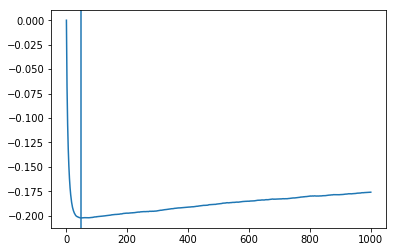

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

params = {'n_estimators': 1000, 'max_depth': 5, 'subsample': 0.5,
          'learning_rate': 0.1, 'min_samples_leaf': 10, 'random_state': 3}
n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1

clf = GradientBoostingClassifier(**params)
clf.fit(X_train,y_train)

def heldout_score(clf, X_test, y_test):
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score

test_score = heldout_score(clf, X_valid, y_valid)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]
plt.plot(x, test_score, label='Test loss')
plt.axvline(x=test_best_iter)

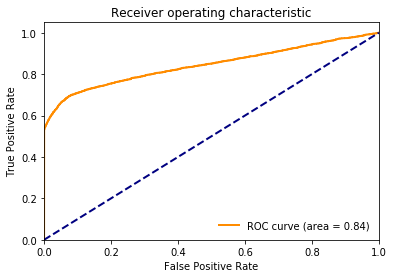

In [22]:
from sklearn.metrics import roc_curve, auc

y_pred = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right",frameon=False)

plt.show()

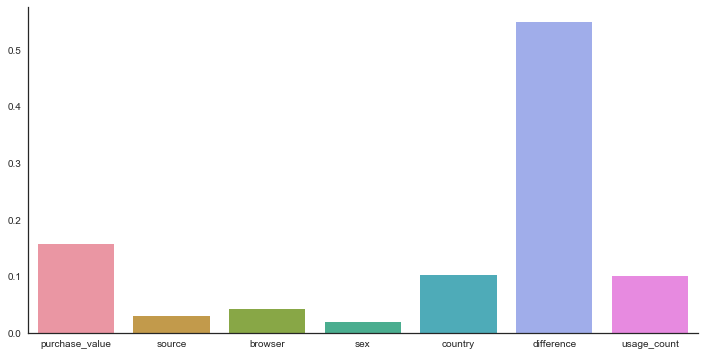

In [23]:
plt.figure(figsize=(12,6))
sns.set(style='white')
ax = sns.barplot(x=X.columns, y =clf.feature_importances_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)

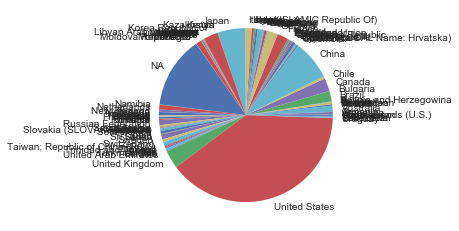

In [24]:
sums = fraud_df[fraud_df["class"] == 1]["class"].groupby(fraud_df.country).sum()
plt.axis('equal')
plt.pie(sums, labels=sums.index)
plt.show()

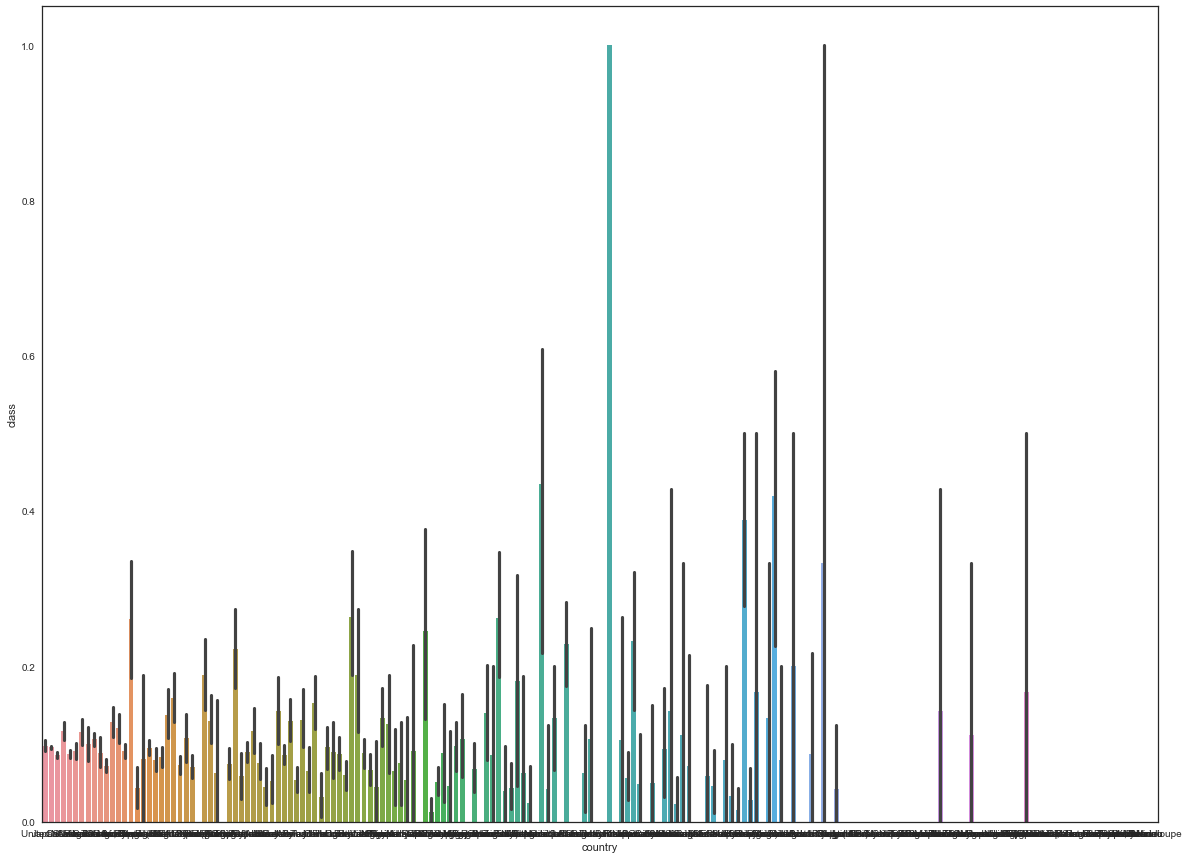

In [25]:
plt.figure(figsize=(20,15))
sns.set(style='white')
ax = sns.barplot(x='country', y='class',data=fraud_df)

In [26]:
fraud_df.groupby('country')['class'].mean().sort_values(ascending=False)[:10]

country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

In [27]:
fraud_df['purchase_value'].nunique()

122

<BarContainer object of 29 artists>

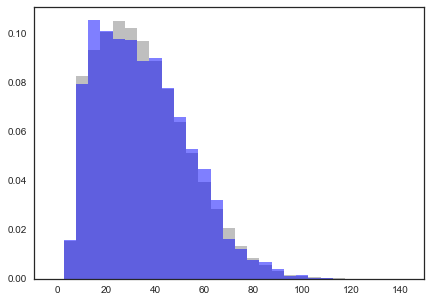

In [28]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()

bins = [i*5 for i in range(30)]
x = fraud_df.loc[fraud_df['class']==0,'purchase_value'].values
hist, bins = np.histogram(x,bins=bins)
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha=0.5,color='grey')
x = fraud_df.loc[fraud_df['class']==1,'purchase_value'].values
hist, bins = np.histogram(x,bins=bins)
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha=0.5,color='blue')

<BarContainer object of 50 artists>

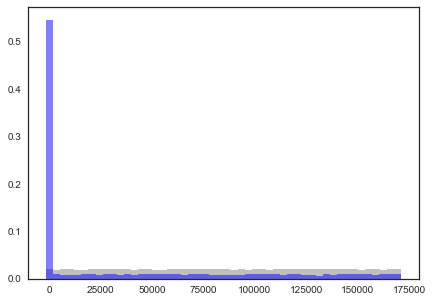

In [32]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()

bins = [i*5 for i in range(30)]
x = data.loc[fraud_df['class']==0,'difference'].values
hist, bins = np.histogram(x,bins=50)
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha=0.5,color='grey')
x = data.loc[fraud_df['class']==1,'difference'].values
hist, bins = np.histogram(x,bins=50)
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha=0.5,color='blue')

D:\WinPython\python-3.6.5.amd64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
D:\WinPython\python-3.6.5.amd64\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(array([ 0.00028947,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([      0.  ,    3454.64,    6909.28,   10363.92,   13818.56,
          17273.2 ,   20727.84,   24182.48,   27637.12,   31091.76,
          34546.4 ,   38001.04,   41455.68,   44910.32,   48364.96,
          51819.6 ,   55274.24,   58728.88,   62183.52,   65638.

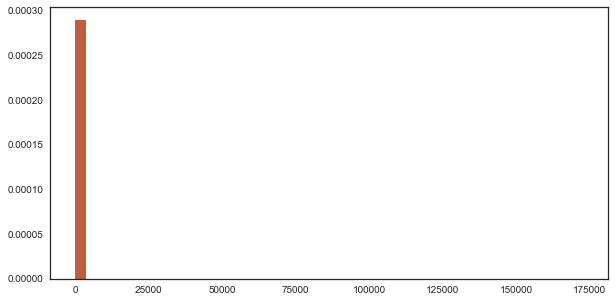

In [33]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()

x = fraud_df.loc[fraud_df['class']==1,'purchase_value'].values
ax.hist(x, normed=True, color='green',bins=bins,alpha=0.5)
x = fraud_df.loc[fraud_df['class']==0,'purchase_value'].values
ax.hist(x, normed=True, color='red',bins=bins,alpha=0.5)

<BarContainer object of 29 artists>

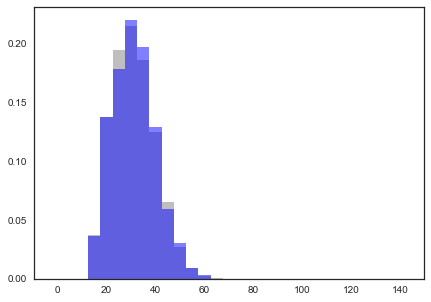

In [34]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()

bins = [i*5 for i in range(30)]
x = fraud_df.loc[fraud_df['class']==0,'age'].values
hist, bins = np.histogram(x,bins=bins)
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha=0.5,color='grey')
x = fraud_df.loc[fraud_df['class']==1,'age'].values
hist, bins = np.histogram(x,bins=bins)
ax.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]), alpha=0.5,color='blue')

# chuan bi he so cho hoi qui logistic


In [35]:
X = pd.concat([pd.get_dummies(fraud_df[['country','source','browser']]),data[['purchase_value','difference','usage_count']]],axis=1)
y = data['class']
X.head()

country_Afghanistan  country_Albania  country_Algeria  country_Angola  \
0                    0                0                0               0   
1                    0                0                0               0   
2                    0                0                0               0   
3                    0                0                0               0   
4                    0                0                0               0   

   country_Antigua and Barbuda  country_Argentina  country_Armenia  \
0                            0                  0                0   
1                            0                  0                0   
2                            0                  0                0   
3                            0                  0                0   
4                            0                  0                0   

   country_Australia  country_Austria  country_Azerbaijan     ...       \
0                  0                0                   0     ...        
1                  0                0                   0     ...        
2                  0                0                   0     ...        
3                  0                0                   0     ...        
4                  0                0                   0     ...        

   source_Direct  source_SEO  browser_Chrome  browser_FireFox  browser_IE  \
0              0           1               1                0           0   
1              0           0               1                0           0   
2              0           1               0                0           0   
3              0           1               0                0           0   
4              0           0               0                0           0   

   browser_Opera  browser_Safari  purchase_value  difference  usage_count  
0              0               0              34     75111.0            1  
1              0               0              16       299.0            1  
2              1               0              15         0.0           12  
3              0               1              44      8201.0            1  
4              0               1              39     72691.0            1  

[5 rows x 193 columns]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2)

In [37]:
from sklearn.linear_model import LogisticRegression


params = {'penalty':'l2', 
          'dual':False, 'tol':0.0001, 
          'C':10.0, 'fit_intercept':True, 
          'intercept_scaling':1, 'class_weight':None, 
          'random_state':None, 'solver':'liblinear', 'max_iter':100, 'multi_class':'ovr', 
          'verbose':0, 'warm_start':False, 'n_jobs':1}

clf = LogisticRegression(**params)
clf.fit(X_train,y_train)

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y_pred = clf.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[27392     0]
 [ 2478   353]]


In [ ]:
#y nghia ket qua tren:
#co 27392 +0 du doan chinh xac
# co 278 +353 ket qua khong chinh xac

In [44]:
# Compute precision, recall, F-measure and support

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.92      1.00      0.96     27392
          1       1.00      0.12      0.22      2831

avg / total       0.92      0.92      0.89     30223



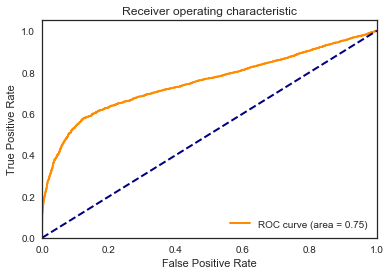

In [31]:
from sklearn.metrics import roc_curve, auc

y_pred = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr,tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right",frameon=False)

plt.show()